In [1]:
import pandas as pd

# 重新加载CSV文件
csv_file_path = r'E:\Code for Project2024\HDFS_v1\preprocessed\HDFS.log_templates.csv'
log_templates_df = pd.read_csv(csv_file_path)

# 显示数据的前几行以确认内容
log_templates_df.head()


,EventId,EventTemplate
0,E1,[*]Adding an already existing block[*]
1,E2,[*]Verification succeeded for[*]
2,E3,[*]Served block[*]to[*]
3,E4,[*]Got exception while serving[*]to[*]
4,E5,[*]Receiving block[*]src:[*]dest:[*]


In [2]:
# 由于环境限制，我们无法直接使用nltk库，但是理论上如果要使用nltk进行分词和停用词去除，代码将如下所示：

# 安装nltk库（如果尚未安装）
# !pip install nltk

# 然后下载nltk中的停用词和punkt tokenizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
import gensim
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel


# 设置停用词
stop_words = set(stopwords.words('english'))

# 定义一个使用nltk的预处理函数
def nltk_preprocess(text):
    # 使用nltk的分词
    words = word_tokenize(text.lower())
    # 去除停用词和非字母字符
    return [word for word in words if word.isalpha() and word not in stop_words]


log_templates_df['Preprocessed'] = log_templates_df['EventTemplate'].apply(nltk_preprocess)


# 创建词袋模型
dictionary = corpora.Dictionary(log_templates_df['Preprocessed'])
corpus = [dictionary.doc2bow(text) for text in log_templates_df['Preprocessed']]




[nltk_data] Error loading punkt: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


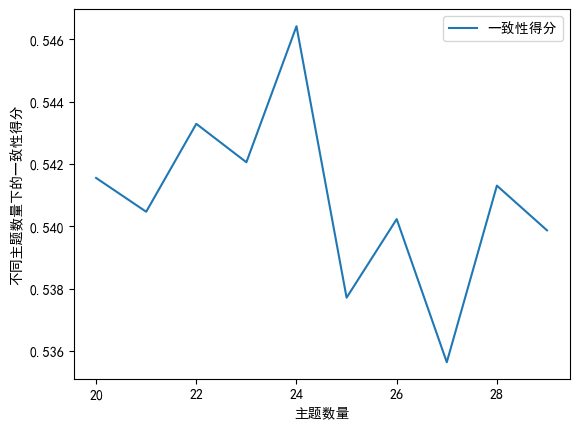

最优解的主题数量: 24
最大一致性得分: 0.5464


In [3]:
from gensim.models import CoherenceModel

# 函数用于计算不同主题数量的模型的一致性得分
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    """
    计算给定主题数量范围内的LDA模型的一致性值。

    参数:
    dictionary : Gensim词典
    corpus : Gensim语料库
    texts : 分词的文本列表
    start : 最小主题数量
    limit : 最大主题数量
    step : 步长

    返回值:
    model_list : 训练的LDA模型列表
    coherence_values : 对应模型的一致性值列表
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# 指定主题数量范围
start = 20
limit = 30
step = 1

# 计算一致性得分
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary, 
    corpus=corpus, 
    texts=log_templates_df['Preprocessed'].tolist(), 
    start=start, 
    limit=limit, 
    step=step
)

# 展示不同主题数量的一致性得分
plt.rc('font',family='SimHei',size=10)
plt.plot(range(start, limit, step), coherence_values, label='一致性得分')
plt.xlabel("主题数量")
plt.ylabel("不同主题数量下的一致性得分")
plt.legend()
plt.show()

# 找出一致性得分最高的主题数量
max_coherence_value = max(coherence_values)
optimal_model_index = coherence_values.index(max_coherence_value)
optimal_model = model_list[optimal_model_index]
optimal_num_topics = range(start, limit, step)[optimal_model_index]

print(f"最优解的主题数量: {optimal_num_topics}")
print(f"最大一致性得分: {max_coherence_value:.4f}")

# 保存最优模型
optimal_lda_model_file = 'E:\\Code for Project2024\\lda_model\\model'
optimal_model.save(optimal_lda_model_file)
# 保存词典
dictionary.save('E:\\Code for Project2024\\lda_model\\dictionary')




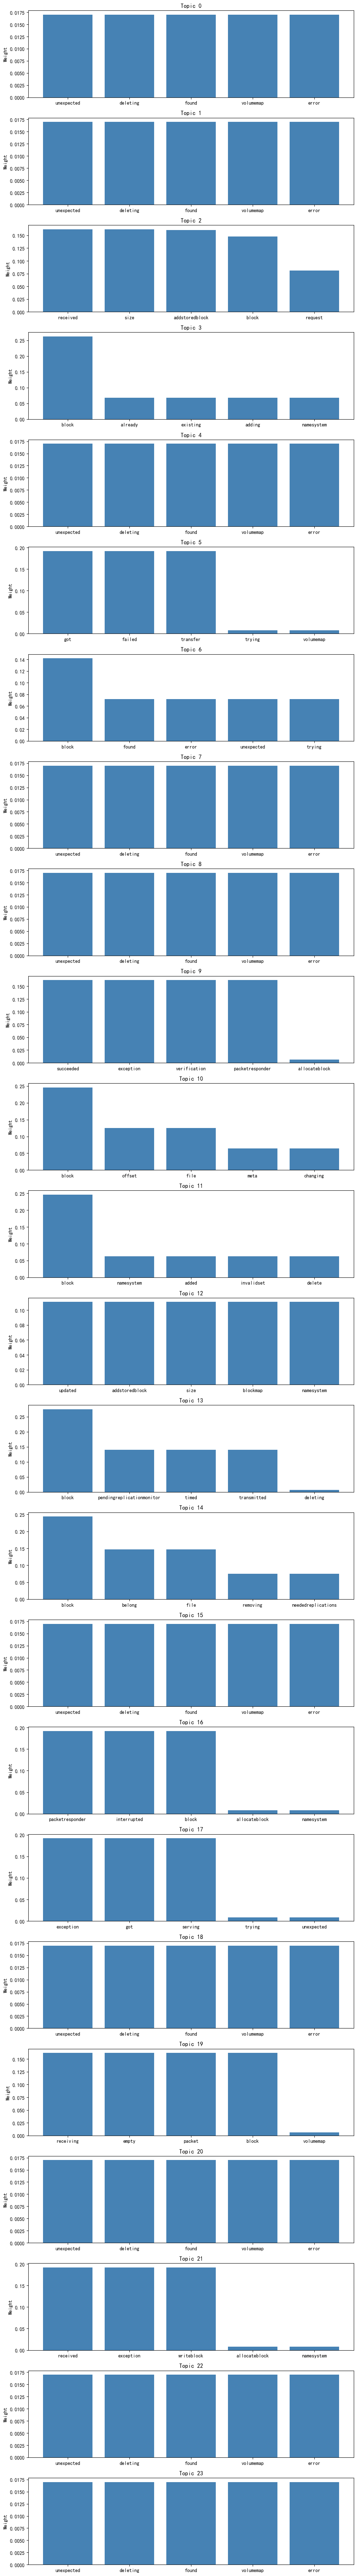

In [4]:
# 设置每个主题显示的词数量
words_per_topic = 5

# 根据主题数量动态调整图表高度
fig_height_per_topic = 3  # 每个主题的图表高度
total_fig_height = optimal_model.num_topics * fig_height_per_topic

# 创建足够高的图表以避免重叠
fig, axes = plt.subplots(optimal_model.num_topics, 1, figsize=(10, total_fig_height))

# 如果主题数量只有1，axes不是列表，这里做一个检查
if optimal_model.num_topics == 1:
    axes = [axes]

for t in range(optimal_model.num_topics):
    ax = axes[t]
    # 提取给定主题的前N个词及其权重
    topic_words = [(word, round(weight, 3)) for word, weight in optimal_model.show_topic(t, topn=words_per_topic)]
    words, weights = zip(*topic_words)
    # 生成条形图
    ax.bar(words, weights, color='steelblue')
    ax.set_title(f'Topic {t}')
    ax.set_ylabel('Weight')

# 调整子图之间的间距
plt.subplots_adjust(hspace=1.0 / optimal_model.num_topics)

plt.tight_layout()
plt.show()
